# IMDB Sentiment Analysis - Transformers

For this assignment, you must make a few adjustments to build and train a transformer encoder model for classification.

The output of a transformer is a sequence, but to build a classifier you need to convert the sequence of vectors into a single vector that you then pass through a classifier head.  This is typically done one of two ways:

1.  Average across the sequence and pass the resulting vector to the classifier.
2. Include a unique class token, often called '<CLS>,' at the beginning of the sequence, then pass the first output vector to the classifier.  Through training, the model learns to aggregate the meaning of the sequence in this particular vector.  The open-source BERT models use this approach.

I've included an almost 'plug-and-play' transformer model below, but you need to change some things:

* Include a '<CLS>' in the vocabulary and at the beginning of every tokenized review your dataloader returns.
* Remove the beginning and end of sequence tokens in the vocabulary and the dataloader's output.
* The transformer model needs to know the index of the padding token, '<PAD>', so it can assign 0 attention weights to the padding in sequences.  Pass that index as variable to the constructor (the init method) and use it to create the padding mask.
* Add a variable to the constructor for the number of transformer layers.
* Determine the values of the parameters needed to construct the model

After you have a baseline model working (embed dim = 64, 1 attention head) then try a few things (create a new model for each):

1.  Baseline model.
2.  Baseline model with enhanced classifier head.
3.  Two attention heads, two transformer layers, and the improved classifier head.

Each of those three models should have its own section in this notebook.  Plot the performance curves together for comparison.

Write a summary section that discusses any differences for the performance of these models and also compares the performance of the models here to the LSTM mode you trained as part of the third part of the sentiment analysis homework.

You may not observe much difference in these variations on the transformer model, but that's OK.  Use this as an opportunity to learn about transformers and how they're used.  What you're doing here isn't much different from a [model like BERT](https://en.wikipedia.org/wiki/BERT_(language_model)) except for both the scale of the model and data.

## Packages and Imports

You may need to install some packages locally or in colb

In [ ]:
# not sure about colab environment, may need to install nltk, torchtext, and ???
# !pip install torchtext
# !pip install nltk
# !pip install portalocker
# !pip install torchdata

In [14]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torch.utils.data import Dataset, DataLoader, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import IMDB
from collections import Counter
from torchtext.vocab import vocab
import math
import string
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils import train_model # NOTE - you'll need utils.py in your current directory

## Process Data, Tokenize, and get DataLoaders

Load the IMDB reviews from torchtext (also in torchdata):

In [5]:
train_iter, _ = IMDB(split=('train', 'test'))
train_dataset = list(train_iter)

torch.manual_seed(42) # for reproducibility
train_dataset, valid_dataset = random_split(train_dataset, [20000,5000])

Tokenize the words in the text data and build vocabulary.  You'll need to add a '<CLS>' token to the vocabulary.   We'll train the transformer encoder to use the output vector corresponding to this input token to classify each sequence.  You also don't need the beginning and end of sequence tokens here.

In [16]:
tokenizer = get_tokenizer('basic_english') #we will be fine with the default english style tokenizer

counter = Counter()
for (label, line) in train_dataset: #loop through the training data
    counter.update(tokenizer(line)) #count the number of unique tokens we see and how often we see them (e.g., we will see "the" a lot, but "sasquatch" mayb

vocab = vocab(counter, min_freq=10, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>')) #create a vocab object, removing any word that didn't occur at least 10 times, and add special vocab items for unkown, begining of sentance, end of sentance, and "padding"

### NEW - 2024
vocab.set_default_index(vocab['<unk>'])

VOCAB_SIZE = len(vocab)
NUM_CLASS = len(np.unique([z[0] for z in train_dataset]))
PADDING_IDX =  vocab["<PAD>"]
print("Vocab: ", VOCAB_SIZE)
print("Num Classes: ", NUM_CLASS)
print("Padding Index: ", PADDING_IDX)

Vocab:  18075
Num Classes:  2
Padding Index:  2


In [17]:
def text_transform(x): #string -> list of integers
    #return [vocab['<BOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']] #vocab acts like a dictionary, handles unkown tokens for us, and we can make it pre and post-pend with the start and end markers respectively.
    return [vocab['<CLS>']] + [vocab[token] for token in tokenizer(x)]
    
def label_transform(x):
    return x-1 #labels are originally [1, 2] but we need them as [0, 1]

def pad_batch(batch):
    """
    Pad items in the batch to the length of the longest item in the batch.
    Also, re-order so that the values are returned (input, label)
    """
    labels = [label_transform(z[0]) for z in batch] #get and transform every label in the batch
    texts = [torch.tensor(text_transform(z[1]), dtype=torch.int64) for z in batch] #get, tokenizer, and put into a tensor every text
    #what is the longest sequence in this batch?
    max_len = max([text.size(0) for text in texts])
    #pad each text tensor by whatever amount gets it to the max_len
    texts = [F.pad(text, (0,max_len-text.size(0)), value=PADDING_IDX) for text in texts]
    #make x and y a single tensor
    x, y = torch.stack(texts), torch.tensor(labels, dtype=torch.int64)

    return x, y

Set the batch size and create the data loaders.

In [18]:
B = 64
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=pad_batch)
valid_loader = DataLoader(valid_dataset, batch_size=B, collate_fn=pad_batch)

## Define the transformer model

This design started from ChatGPT and underwent several tweaks.  It's the architecture we discussed in class on April 18.  

Note that transformers, like RNNs,  in PyTorch expect batches of the form (S,B) where S is the sequence length and B is the batch size.  We can override this, as with RNNs, by using `batch_first = True`.

You need to add additional variables in the constructor for the index for the padding token and the number of transformer layers.  Your model won't work well if you don't have the '<CLS>' token at the beginning of your sequences.

In [19]:
class TransformerModel(nn.Module):
    def __init__(self, num_tokens, dim_model, num_heads, num_classes, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.pos_encoder = PositionalEncoding(dim_model, dropout)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=dim_model, nhead=num_heads, dropout=dropout, batch_first=True),
            num_layers=1
        )
        self.output_layer = nn.Linear(dim_model, num_classes)

    def forward(self, x):
        pad_mask = (x==4) # (B,s) Change the value to the index of your pad token, something like (x==self.pad_idx), you'll have to add to the constructor
        x = self.embedding(x)  # x shape: (B, S, D)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x, src_key_padding_mask=pad_mask)
        x = self.output_layer(x[:, 0, :])  # Assuming <cls> token at index 0 for classification
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## Baseline Model

In [ ]:
# Model Configuration (FILL THESE IN)
num_classes = 
dim_model =   # embedding dimensions (at least 32)
num_heads =   # number of attention heads
num_tokens =   # size of vocabulary

# Model Instantiation
transformer_model = TransformerModel(num_tokens, dim_model, num_heads, num_classes)  # You need two more arugments here

loss_function = nn.CrossEntropyLoss()
num_epochs=10

metrics = {'accuracy': torchmetrics.Accuracy(task='multiclass', num_classes = num_classes),}

transformer_results = train_model(transformer_model, 
                                  loss_function,
                                  epochs = num_epochs,
                                  metrics = metrics,
                                  train_loader = train_loader,
                                  val_loader = valid_loader)

## Plot some results

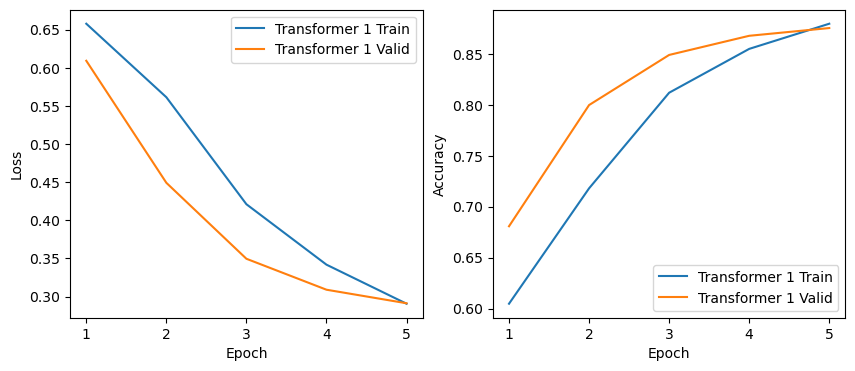

In [21]:
def make_plots(label_df_dict):
    fig,ax = plt.subplots(1,2,figsize=(10,4))
    for label,df in label_df_dict.items():
        sns.lineplot(x='Epoch',y='train_loss',data=df,label=f'{label} Train',ax=ax[0]);
        sns.lineplot(x='Epoch',y='val_loss',data=df,label=f'{label} Valid',ax=ax[0]);
        ax[0].set_ylabel('Loss')
    for label,df in label_df_dict.items():
        sns.lineplot(x='Epoch',y='train_accuracy',data=df,label=f'{label} Train',ax=ax[1]);
        sns.lineplot(x='Epoch',y='val_accuracy',data=df,label=f'{label} Valid',ax=ax[1]);
        ax[1].set_ylabel('Accuracy')


results_dict = {'Transformer 1':transformer_results} # can add more dataframes in this dict to compare results
make_plots(results_dict)